# Music Recommendation Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)
import joblib


In [2]:
df = pd.read_csv('./data/processed_music_data.csv')
df.head()

,user_id,spotify_id,liked,valence,year,acousticness,artists,danceability,duration_ms,energy,...,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,fedf7808ee251872210b2d77335caa0a,2QloUyCqK1enErCSmUniNu,1,0.744,2011,0.0169,"['Tyler, The Creator']",0.730,251653,0.762,...,0.074900,11,0.1970,-5.383,1,Yonkers,48,2011-02-15,0.3220,79.069
1,4282602f0e8b18b47a8411c0187fe6ec,0BCPKOYdS2jbQ8iyB56Zns,1,0.255,2002,0.5990,['Coldplay'],0.577,307880,0.749,...,0.011500,5,0.1830,-7.215,0,Clocks,77,2002-08-08,0.0279,130.970
2,4282602f0e8b18b47a8411c0187fe6ec,4rzEjTzcG4sP28IUnRwlex,1,0.663,1996,0.0632,['Weezer'],0.468,243667,0.721,...,0.000000,1,0.0784,-4.382,1,El Scorcho,38,1996-09-24,0.0611,147.913
3,8aac4544c9b7e112d7643057aa1786ed,7MutmAL7btZWW6S50zgoCQ,1,0.679,1996,0.2340,['DJ Kool'],0.701,287973,0.851,...,0.000000,0,0.9570,-6.566,1,Let Me Clear My Throat - Live,45,1996-01-01,0.3730,103.208
4,d53894622afa69721e87bb7fb4ad4bc2,6rUcS9i07F6okIe8wujs5J,1,0.746,2009,0.6430,['Gucci Mane'],0.741,246013,0.658,...,0.000003,7,0.3070,-7.758,1,Lemonade,61,2009-12-04,0.0853,142.057


In [3]:
df.shape

(1004344, 21)

In [4]:
# Number of unique values per col
unique_counts = df.nunique().sort_values(ascending=True)
print(unique_counts)

explicit                 2
liked                    2
mode                     2
key                     12
popularity             100
year                   100
danceability          1206
speechiness           1605
valence               1703
liveness              1731
energy                2228
acousticness          4574
instrumentalness      5399
release_date         10393
loudness             23972
artists              28699
duration_ms          43899
user_id              62027
tempo                73628
name                105306
spotify_id          129911
dtype: int64


In [5]:
# User id, artist unique counts
print(unique_counts['user_id'], unique_counts['artists'])

62027 28699


In [6]:
df.columns

Index(['user_id', 'spotify_id', 'liked', 'valence', 'year', 'acousticness',
       'artists', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'name',
       'popularity', 'release_date', 'speechiness', 'tempo'],
      dtype='object')

In [7]:
num_cols = df.select_dtypes(include=[np.number]).columns.to_list()
cat_cols = [col for col in df.columns if col not in num_cols]
print(num_cols)
print(cat_cols)


['liked', 'valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']
['user_id', 'spotify_id', 'artists', 'name', 'release_date']


<Figure size 1500x1000 with 0 Axes>

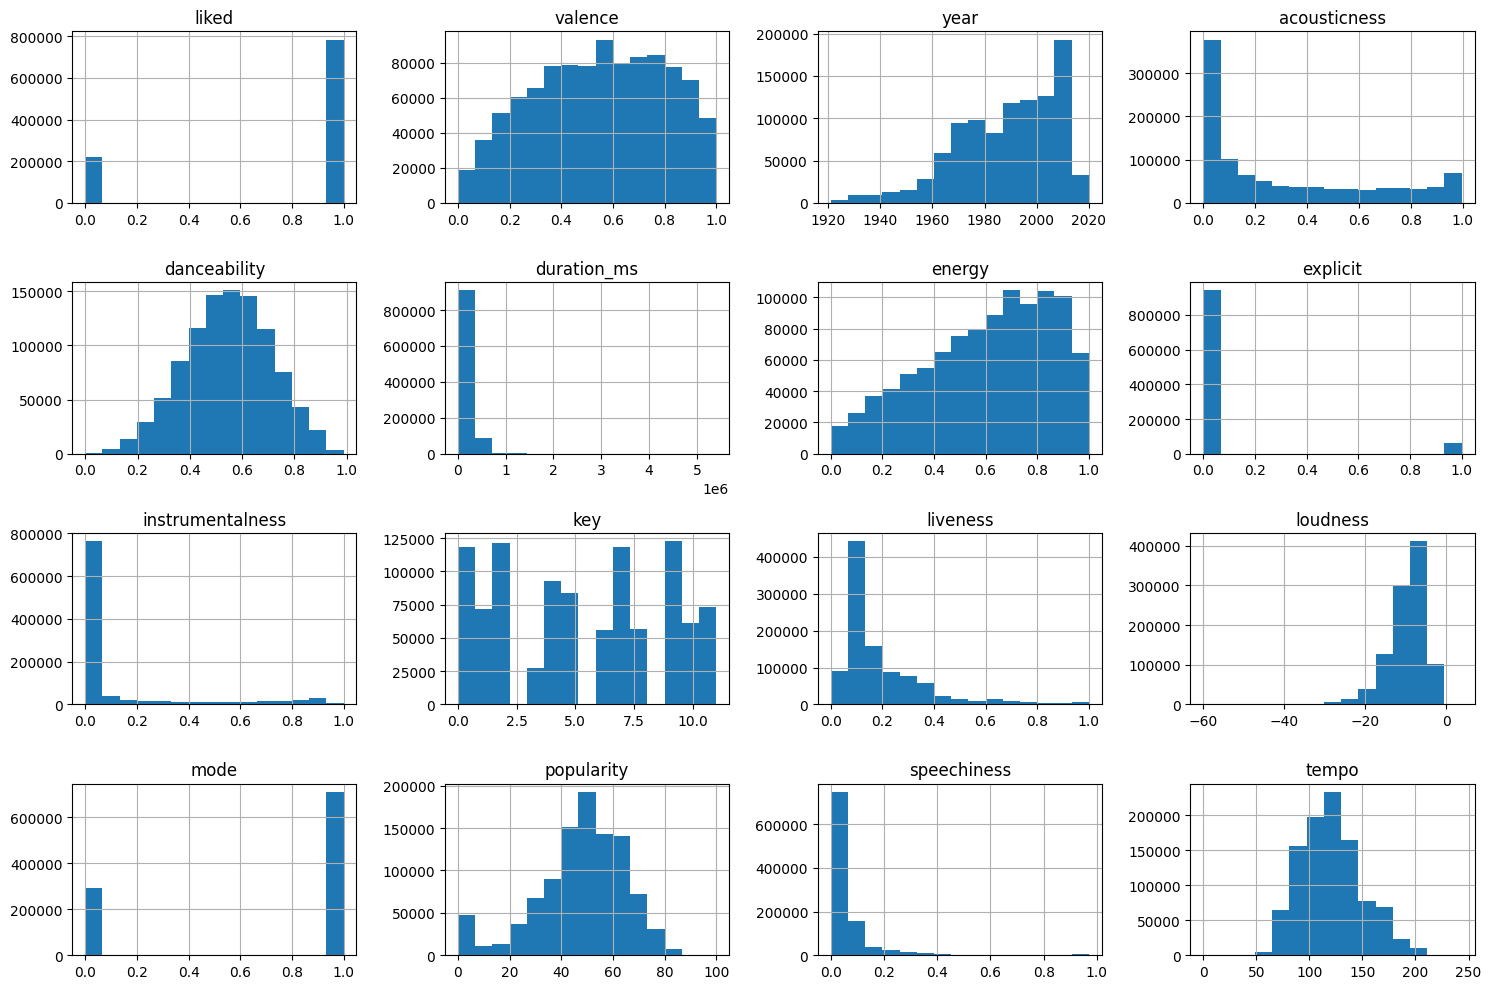

In [8]:
# Numeric columns
plt.figure(figsize=(15, 10))
df[num_cols].hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.tight_layout()
plt.show()


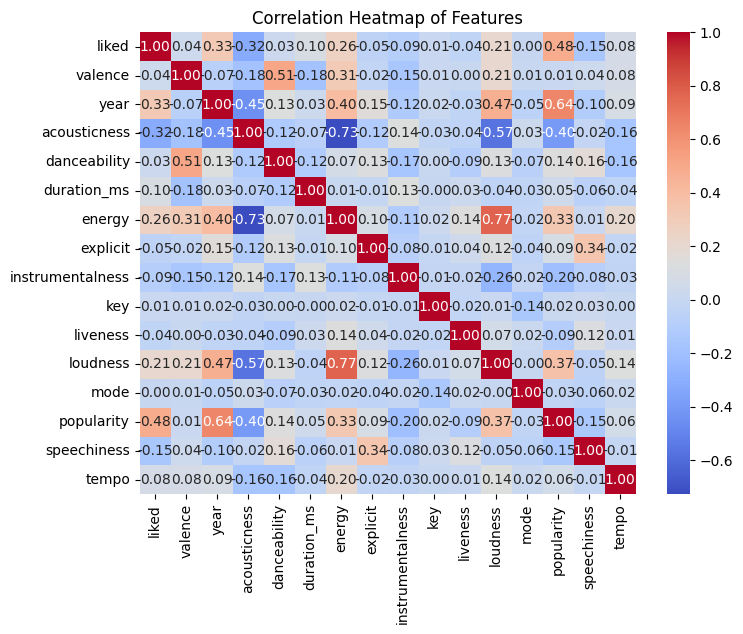

In [9]:
correlation_matrix = df[num_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

In [10]:
# key acts as categorical data
df_dummies = pd.get_dummies(df, columns=["key"], drop_first=True, dtype=int)

In [11]:
X = df_dummies.drop(cat_cols + ['liked'], axis=1)
y = df_dummies['liked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.columns

Index(['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'instrumentalness', 'liveness', 'loudness',
       'mode', 'popularity', 'speechiness', 'tempo', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11'],
      dtype='object')

In [13]:
def evaluate_cv_and_test(pipe, X_train, y_train, X_test, y_test):
    best_model = pipe.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba_pos = best_model.predict_proba(X_test)[:, 1]

    print(f'''Test Set Performance:
accuracy: {accuracy_score(y_test, y_pred):.4f}
precision: {precision_score(y_test, y_pred):.4f}
recall: {recall_score(y_test, y_pred):.4f}
f1: {f1_score(y_test, y_pred):.4f}
ROC AUC: {roc_auc_score(y_test, y_proba_pos):.4f}''')

    return best_model

In [ ]:
rf_pipe = Pipeline([("clf", RandomForestClassifier(random_state=42))])
rf_fitted = evaluate_cv_and_test(rf_pipe, X_train, y_train, X_test, y_test)

In [ ]:
filename = "random_forest_model.joblib"
joblib.dump(rf_fitted, filename)

['random_forest_model.joblib']